In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import read_r
from scipy.interpolate import interp1d
from param_watervalues import Reservoir
from time import time
from random import randint, seed

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = -1

In [5]:
# study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/ERAA_scandinavie"
# output_path = study_path+"/user/fast_fi00"
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/OneNodeBase"
output_path = study_path+"/user"

In [6]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

In [7]:
S = 52
NTrain = 10
H = 168

In [8]:
def create_weekly_problem_itr(k,s,output_path, reservoir, pen_low, pen_high,pen_final):
    model = retrieve_problem(k+1,s+1,output_path)
    model.controls.xslp_log = -1

    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]

    model_copy = model.copy()

    x_s = xp.var("x_s",lb = 0, ub = reservoir.capacity)
    model_copy.addVariable (x_s)          # State at the begining of the current week

    x_s_1 = xp.var("x_s_1",lb = 0, ub = reservoir.capacity)
    model_copy.addVariable (x_s_1) # State at the begining of the following week

    U = xp.var("u",lb = -reservoir.P_pump[7*s]*reservoir.efficiency*H, ub = reservoir.P_turb[7*s]*H)
    model_copy.addVariable (U) # State at the begining of the following week

    model_copy.addConstraint(x_s_1 == x_s - U + reservoir.inflow[s,k]*H)

    y = xp.var("y")

    model_copy.addVariable (y)    # Penality for violating guide curves

    if s!=S-1:
        model_copy.addConstraint(y >=  -pen_low* (x_s_1 - reservoir.Xmin[s]))
        model_copy.addConstraint(y >=  pen_high* (x_s_1 - reservoir.Xmax[s]))
    else :
        model_copy.addConstraint(y >=  -pen_final* (x_s_1 - reservoir.Xmin[s]))
        model_copy.addConstraint(y >=  pen_final* (x_s_1 - reservoir.Xmax[s]))

    model_copy.chgmcoef(binding_id,[U],[-1])
    model_copy.chgrhs(binding_id,[0])

    z = xp.var("z",lb = float('-inf'), ub =  float('inf'))

    model_copy.addVariable (z) # Auxiliar variable to introduce the piecewise representation of the future cost

    model_copy.chgobj([y,z], [1,1])

    return([model,binding_id, model_copy,x_s,x_s_1, z, y])
    

In [9]:
def modify_weekly_problem_itr(model,binding_id,u):

    model.chgrhs(binding_id,[u])

    model.lpoptimize()

    if model.attributes.lpstatus==1:
        beta = model.getObjVal()
        lamb = model.getDual(binding_id)[0]
        return(beta,lamb,model.attributes.SIMPLEXITER, model.attributes.TIME)
    else :
        raise(ValueError)

In [10]:
def calculate_VU(reward, reservoir,X,U, pen_low, pen_high, pen_final):
    V = np.zeros((len(X), S+1, NTrain))

    for s in range(S-1,-1,-1):#
        
        if s==S-1:
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_final*(reservoir.Xmin[s]),0,0,-pen_final*(reservoir.capacity-reservoir.Xmax[s])])
        else :
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])

        for k in range(NTrain):
            V_fut = interp1d(X, V[:, s+1,k])
            Gs = lambda x: min([reward[i][s,k,0]*x+reward[i][s,k,1] for i in range(len(reward))])
            for i in range(len(X)):
                Vu = float('-inf')

                for i_fut in range(len(X)):
                    u = -X[i_fut] + X[i] + reservoir.inflow[s,k]*H
                    if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
                        G = Gs(u)
                        penalty = pen(X[i_fut])
                        if (G + V[i_fut, s+1,k]+penalty) > Vu:
                            Vu = G + V[i_fut, s+1,k]+penalty

                for u in range(len(U[s][k])):
                    state_fut = min(reservoir.capacity,X[i] - U[s][k][u] + reservoir.inflow[s,k]*H) 
                    if 0 <= state_fut :
                        penalty = pen(state_fut)
                        G = Gs(U[s][k][u])
                        if (G + V_fut(state_fut)+penalty) > Vu:
                            Vu = (G + V_fut(state_fut)+penalty)

                Umin = X[i]+ reservoir.inflow[s,k]*H-reservoir.Xmin[s]
                if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
                    state_fut = X[i] - Umin + reservoir.inflow[s,k]*H
                    penalty = pen(state_fut)
                    if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                        Vu = Gs(Umin) + V_fut(state_fut)+penalty

                Umax = X[i]+ reservoir.inflow[s,k]*H-reservoir.Xmax[s]
                if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
                    state_fut = X[i] - Umax + reservoir.inflow[s,k]*H 
                    penalty = pen(state_fut)
                    if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                        Vu = Gs(Umax) + V_fut(state_fut)+penalty
            
                V[i, s, k] = Vu + V[i,s,k]
        V[:,s,:] = np.repeat(np.mean(V[:,s,:],axis=1,keepdims=True),NTrain,axis=1)
    return np.mean(V,axis=2)

In [11]:
def filter_coeff(G, lb=-np.inf,ub=np.inf):
    G = np.reshape(np.concatenate(G),(len(G),2))
    idx = np.ones(len(G), dtype=bool)
    if len(G)>=2:
        m = xp.problem()
        m.controls.xslp_log = -1
        x = xp.var(lb=lb,ub=ub)
        y = xp.var(lb=-xp.infinity,ub=xp.infinity)
        m.addVariable(x,y)
        m.setObjective (y, sense=xp.maximize)
        
        for j in range(len(G)):
            for k in range(len(G)):
                if k!=j and idx[k]:
                    m.addConstraint(y<=(G[j,0]-G[k,0])*x+G[j,1]-G[k,1])
            if m.attributes.rows>=1:
                m.lpoptimize()
                if m.getObjVal()<0:
                    idx[j] = False
                m.delConstraint(range(0,m.attributes.rows))
        G = G[idx]
        # G = G[np.lexsort((G[:, 1], G[:, 0]))]

        # if np.isfinite(lb):
        #     y_lb = G[:,0]*lb+G[:,1]
        #     G = G[(y_lb[::-1]==np.maximum.accumulate(y_lb[::-1]))[::-1]]

        # if np.isfinite(ub):
        #     y_ub = G[:,0]*ub+G[:,1]
        #     G = G[(y_ub==np.maximum.accumulate(y_ub))]
        #     # G = np.concatenate((G,np.array([[0,G[-1,0]*ub+G[-1,1]]])))
        #     # G = G[np.lexsort((G[:, 1], G[:, 0]))]

        G = np.unique(G,axis=0)
    return(G)

In [12]:
def legendre(A,lb=-np.inf,ub=np.inf):
    coeff = [((A[i,1]-A[i+1,1])/(A[i+1,0]-A[i,0]),(A[i,0]*A[i+1,1]-A[i+1,0]*A[i,1])/(A[i+1,0]-A[i,0])) for i in range(len(A)-1)]
    if np.isfinite(lb):
        coeff.append((lb,-A[0,0]*lb-A[0,1]))
    elif A[0,0]>0:
        raise ValueError
    if np.isfinite(ub):
        coeff.append((ub,-A[-1,0]*ub-A[-1,1]))
    elif A[-1,0]<0:
        raise ValueError
    coeff = filter_coeff(np.array(coeff))
    return(coeff)

In [13]:
def add(A,B):
    res = np.array([(i[0]+j[0],i[1]+j[1]) for i in A for j in B])
    res = filter_coeff(res)
    return(res)

In [14]:
def transform(V, apport):
    res = V
    res[:,1] = V[:,0]*apport+V[:,1]
    return(res)

In [15]:
def calculate_VU_continu(reward, reservoir, X, U, pen_low, pen_high):
    V = [np.zeros((1,2)) for s in range(S+1)]

    for s in range(S-1,-1,-1):#
        Vu = np.zeros((1,2))
        for k in range(NTrain):
            G = [-reward[i][s,k] for i in range(len(reward))]
            V_fut = transform(V[s+1], reservoir.inflow[s,k]*H)
            
            G = filter_coeff(G,-reservoir.P_pump[7*s]*H,reservoir.P_turb[7*s]*H)
            V_fut = filter_coeff(V_fut,0,reservoir.capacity)

            G_etoile = legendre(G,-reservoir.P_pump[7*s]*H,reservoir.P_turb[7*s]*H)
            V_fut_etoile = legendre(V_fut,0,reservoir.capacity)
                
            Vu_etoile = add(G_etoile,V_fut_etoile)
            Vu = add(Vu,legendre(Vu_etoile))
        V[s] = filter_coeff(Vu/NTrain,0,reservoir.capacity)

                
    return V

In [16]:
def compute_x(reservoir,X,U,V,reward,pen_low,pen_high, pen_final, itr):
    initial_x = [reservoir.initial_level]
    controls = np.zeros((S,NTrain))
    cout = 0
    seed(19*itr)
    
    for s in range(S):
        cout_s =0
        V_fut = interp1d(X, V[:, s+1])
        k = randint(0,NTrain-1)
        
        if s==S-1:
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_final*(reservoir.Xmin[s]),0,0,-pen_final*(reservoir.capacity-reservoir.Xmax[s])])
        else :
            pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
        Gs = lambda x: min([reward[i][s,k,0]*x+reward[i][s,k,1] for i in range(len(reward))])

        Vu = float('-inf')

        for i_fut in range(len(X)):
            u = -X[i_fut] + initial_x[-1] + reservoir.inflow[s,k]*H
            if -reservoir.P_pump[7*s]*H <= u <= reservoir.P_turb[7*s]*H:
                G = Gs(u)
                penalty = pen(X[i_fut])
                if (G + V[i_fut, s+1]+penalty) > Vu:
                    Vu = G + V[i_fut, s+1]+penalty
                    xf = X[i_fut]
                    cout_s = G

        for u in range(len(U[s][k])):
            state_fut = min(reservoir.capacity,initial_x[-1] - U[s][k][u] + reservoir.inflow[s,k]*H) 
            if 0 <= state_fut :
                penalty = pen(state_fut)
                G = Gs(U[s][k][u])
                if (G + V_fut(state_fut)+penalty) > Vu:
                    Vu = (G + V_fut(state_fut)+penalty)
                    xf = state_fut
                    cout_s =G

        Umin = initial_x[-1]+ reservoir.inflow[s,k]*H-reservoir.Xmin[s]
        if -reservoir.P_pump[7*s]*H <= Umin <= reservoir.P_turb[7*s]*H:
            state_fut = initial_x[-1] - Umin + reservoir.inflow[s,k]*H
            penalty = pen(state_fut)
            if (Gs(Umin) + V_fut(state_fut)+penalty) > Vu:
                Vu = Gs(Umin) + V_fut(state_fut)+penalty
                xf = state_fut
                cout_s = Gs(Umin)

        Umax = initial_x[-1]+ reservoir.inflow[s,k]*H-reservoir.Xmax[s]
        if -reservoir.P_pump[7*s]*H <= Umax <= reservoir.P_turb[7*s]*H:
            state_fut = initial_x[-1] - Umax + reservoir.inflow[s,k]*H 
            penalty = pen(state_fut)
            if (Gs(Umax) + V_fut(state_fut)+penalty) > Vu:
                Vu = Gs(Umax) + V_fut(state_fut)+penalty
                xf = state_fut
                cout_s = Gs(Umax)

        initial_x.append(xf)
        controls[s] = -(initial_x[s+1]-initial_x[s]-reservoir.inflow[s,k]*H)
        cout += cout_s
    return(initial_x, controls, cout)

In [17]:
def compute_upper_bound(reservoir,list_models,X,V):
    cout = 0
    controls = np.zeros((S,NTrain))
    for k in range(NTrain):
        
        level_i = reservoir.initial_level
        for s in range(S):
            print(f"{k} {s}",end="\r")
            m = list_models[s][k]
            # Future cost: piecewise representation of the future cost
            nb_cons = m[2].attributes.rows
          

            for i in range(len(X)-1):
                if (V[i+1, s+1]<float('inf'))&(V[i, s+1]<float('inf')):
                    m[2].addConstraint(m[5] >= (V[i+1, s+1] - V[i, s+1]) / (X[i+1] - X[i]) * (m[4] - X[i]) + V[i, s+1])

            cst_initial_level = m[3] == level_i
            m[2].addConstraint(cst_initial_level)

            m[2].lpoptimize()

            if m[2].attributes.lpstatus==1:
                beta = m[2].getObjVal()
                xf = m[2].getSolution(m[4])
                z = m[2].getSolution(m[5])
                y = m[2].getSolution(m[6])
                m[2].delConstraint(range(nb_cons,m[2].attributes.rows))
                cout += beta
                controls[s,k]=-(xf-level_i-reservoir.inflow[s,k]*H)
                level_i = xf
                if s!=S-1:
                    cout += - z - y
                
            else :
                raise(ValueError)
    return(cout/NTrain, controls)
            

In [18]:
def itr_control(reservoir:Reservoir, output_path, pen_low, pen_high,X, N, pen_final):

    # seed(19)
    
    list_models = [[] for i in range(S)]
    for s in range(S):
        for k in range(NTrain):
            m = create_weekly_problem_itr(k=k,s=s,output_path=output_path,reservoir=reservoir,pen_low=pen_low,pen_high=pen_high,pen_final=pen_final)
            list_models[s].append(m)
    
    # k = randint(0,NTrain-1)
    # initial_x = [reservoir.initial_level]
    # controls = []
    # for s in range(S):
    #     xf = initial_x[-1] + max(reservoir.inflow[s,k]*H-reservoir.P_turb[7*s]*H,0)
    #     initial_x.append(xf)
    #     controls.append(-(initial_x[s+1]-initial_x[s]-reservoir.inflow[s,k]*H))
    V = np.zeros((len(X), S+1))

    G = [np.zeros((S+1,NTrain,2))]
    U = [[[reservoir.P_turb[7*s]*H,-reservoir.P_pump[7*s]*H] for k in range(NTrain)] for s in range(S)]
    itr_tot = []
    tot_t = []

    best_cost = np.zeros(NTrain)
    best_lb = np.zeros(NTrain)

    # upper_bound, controls = compute_upper_bound(reservoir,list_models,X,V,pen_low,pen_high) 
    i = 0
    gap = 1e3
    while gap>=1e-2 or gap<=-1e-3:
        debut = time()
        Gj = np.zeros((S+1,NTrain,2))
        current_cost = np.zeros(NTrain)
        current_itr = np.zeros((S,NTrain,2))
        # k = randint(0,NTrain-1)
        initial_x, controls, lb = compute_x(reservoir=reservoir,X=X,U=U,V=V,reward=G,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final, itr=i)
        for k in range(NTrain):
            # initial_x, controls, lb = compute_x(reservoir=reservoir,k=k,X=X,U=U,V=V,reward=G,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final)
            # best_lb[k] = max(best_lb[k],-lb)
            for s in range(S):
                print(f"{k} {s}",end="\r")
                m = list_models[s][k]
                beta,lamb,itr, t = modify_weekly_problem_itr(model=m[0],binding_id=m[1],u=controls[s][k])
                Gj[s,k,0] = -lamb
                Gj[s,k,1] = -beta + lamb*controls[s][k]
                U[s][k].append(controls[s][k])
                current_cost[k] += beta
                current_itr[s,k] = (itr,t)
            # V = calculate_VU(reward=G+[Gj],reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final)
        G.append(Gj)
        itr_tot.append(current_itr)

        # V = calculate_VU_continu(reward=G,reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high)
        
        # V0_continu = max([V[0][i,0]*reservoir.initial_level+V[0][i,1] for i in range(len(V[0]))])

        V = calculate_VU(reward=G,reservoir=reservoir,X=X,U=U,pen_low=pen_low,pen_high=pen_high, pen_final=pen_final)
        V_fut = interp1d(X, V[:, 0])
        V0 = V_fut(reservoir.initial_level)

        if np.mean(best_cost)==0:
            best_cost = current_cost
        else :
            best_cost = np.minimum(best_cost,current_cost)
        upper_bound, controls = compute_upper_bound(reservoir,list_models,X,-V) 
        gap = upper_bound+V0
        print(gap, upper_bound,-V0, np.mean(best_lb),np.mean(best_cost)) #,V0_continu)
        gap = gap/-V0
        fin = time()
        i+=1
        tot_t.append(fin-debut)
    return (V, G, np.array(itr_tot),tot_t, U)

In [19]:
pen_low = 3#10000
pen_high = 0
pen_final = 3#10000

In [20]:
# reservoir = Reservoir(5530000,1,study_path,"fi00","reservoir")
reservoir = Reservoir(1e7,1,study_path,"area","reservoir", final_level=True)

In [21]:
xNsteps = 50
X = np.linspace(0, reservoir.capacity, num = xNsteps)

In [22]:
vb, G, itr, temps_tot, U = itr_control(reservoir, output_path, pen_low, pen_high, X,2, pen_final) 
# 6m6s cas simple pour 20 niveaux de stock
# 9m0s cas simple pour 50 niveaux de stock 4 itérations
# 86m pour 50 niveaux de stock eraa_scandinavie 10-20 min récupération pb puis 3 itérations (1 simu avec Antares prend 9 minutes > ici c'est plus long)

3126555.4689994752 44492724.575548075 41366169.1065486 0.0 44364761.75749973
1625072.6214780062 44362746.49843025 42737673.876952246 0.0 44364761.75749973
778031.401663579 44071586.625800095 43293555.22413652 0.0 44364761.75749973
403902.84111891687 43812407.7350952 43408504.893976286 0.0 44364761.75749973


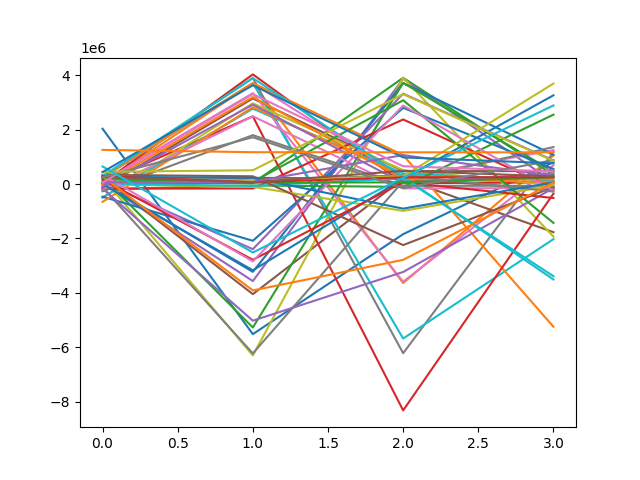

In [23]:
plt.figure()
for s in range(S):
    plt.plot(U[s][0][2:])

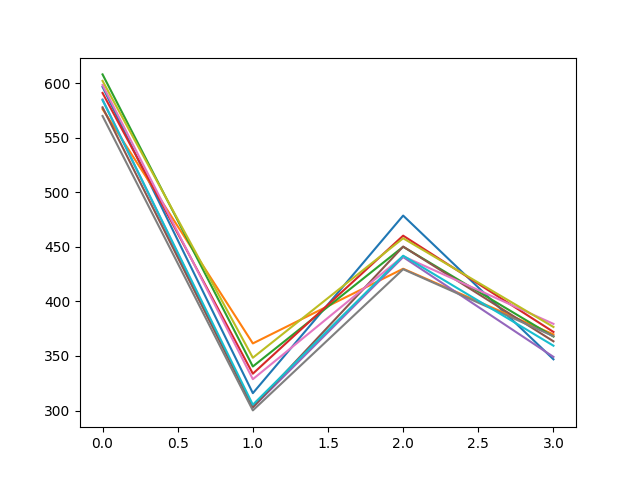

In [24]:
plt.figure()
for k in range(NTrain):
    plt.plot(np.arange(len(itr)),np.mean(itr[:,:,k,0],axis=1))

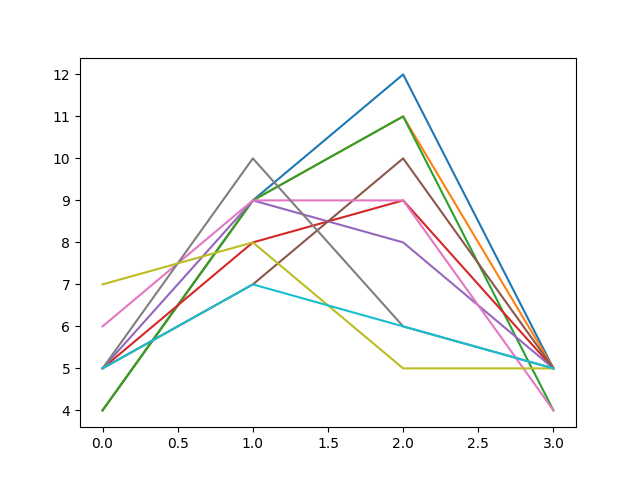

In [25]:
plt.figure()
for k in range(NTrain):
    plt.plot(np.arange(len(itr)),np.sum(itr[:,:,k,1],axis=1))

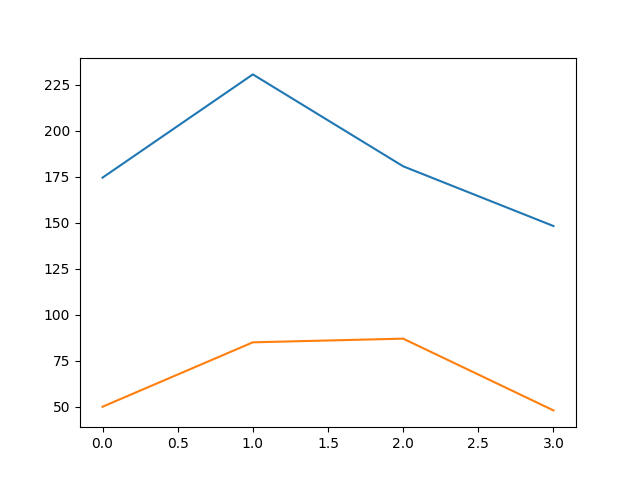

In [26]:
plt.figure()
plt.plot(temps_tot)
plt.plot(np.sum(np.sum(itr[:,:,:,1],axis=1),axis=1))

In [27]:
%lprun -f itr_control res=itr_control(reservoir, output_path, pen_low, pen_high, X,2, pen_final) 

347500903.8935027 4409661559.951101 4062160656.0575986 0.0 4659143734.449353
59233161.71328735 4400193602.43215 4340960440.718863 0.0 4614325699.429077
29904856.238812447 4400405823.730135 4370500967.4913225 0.0 4555877042.147193


Timer unit: 1e-07 s

Total time: 6432.14 s

Could not find file C:\Users\gerbauxjul\AppData\Local\Temp\ipykernel_14360\2221430856.py
Are you sure you are running this program from the same directory
that you ran the profiler from?
Continuing without the function's contents.

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           
     2                                           
     3                                           
     4                                           
     5         1        416.0    416.0      0.0  
     6        53        438.0      8.3      0.0  
     7       572      19710.0     34.5      0.0  
     8       520        1e+10    2e+07     16.8  
     9       520      67619.0    130.0      0.0  
    10                                           
    11                                           
    12                                           
    13                                           
    14     

In [27]:
penalties = np.zeros((xNsteps, S+1))
for s in range(S+1):
    pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
    for i in range(xNsteps):
        penalties[i,s] = pen(X[i])

In [18]:
uSteps = 30
U = [np.linspace(-reservoir.P_pump[7*s]*H, reservoir.P_turb[7*s]*H,num=uSteps) for s in range(S)]

In [19]:
s = 10

In [20]:
i = np.argmax([X>=reservoir.Xmin[s]])
j = np.argmin([X<=reservoir.Xmax[s]])
# i = 0
# j = xNsteps

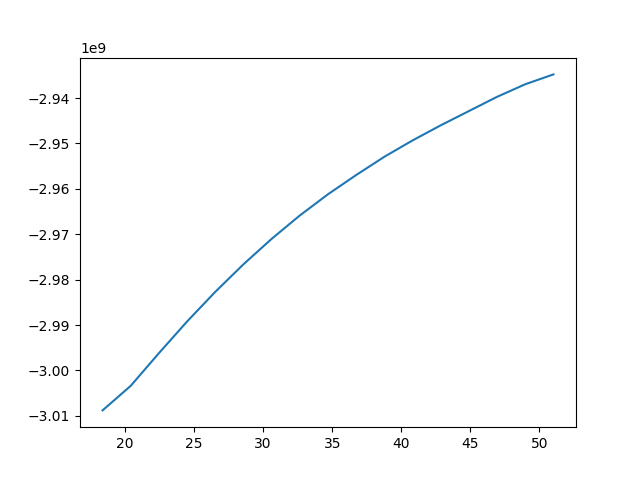

In [21]:
plt.figure()
plt.plot(X[i:j]/reservoir.capacity*100,vb[i:j,s])#-penalties[i:j,s]

In [30]:
len(G)

5

In [31]:
G[0].shape

(53, 10, 2)

In [38]:
U[s][0]

[8400000.0,
 -8400000.0,
 41377.0,
 -3226043.122448979,
 3714846.3877551025,
 1076905.1632653056]

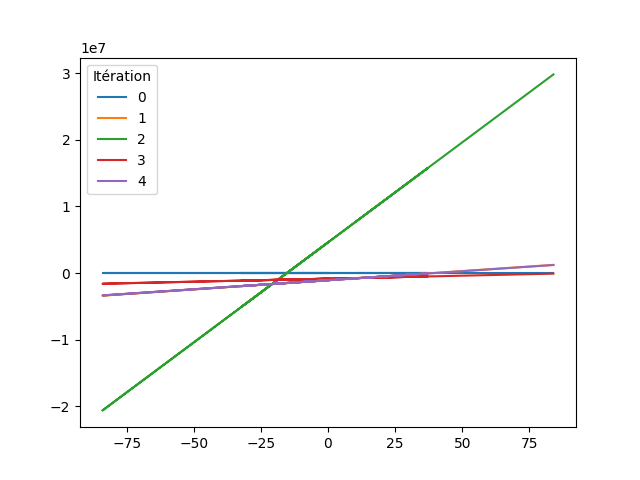

In [40]:
plt.figure()
s = 10
for k in range(len(G)):
    g = G[k][s,0,0]*np.array(U[s][0])+G[k][s,0,1]
    plt.plot(np.array(U[s][0])/reservoir.capacity*100,g,label=f"{k}")#-penalties[i:j,s]
plt.legend(title="Itération")

In [170]:
[G[k][s,:] for k in range(len(G))]

[array([ 1.59989961e+02, -1.38189455e+08]),
 array([ 1.41158368e+01, -1.08215971e+08]),
 array([ 1.41258506e+01, -1.08218965e+08]),
 array([ 1.41258506e+01, -1.08218965e+08]),
 array([ 1.41258506e+01, -1.08218965e+08]),
 array([ 1.41258506e+01, -1.08218965e+08])]